## 1.Imports

In [39]:
# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# PyTorch
import torch
from torch.utils.data import Dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader


# Transformers
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup,
)
import os
import pandas as pd
from pathlib import Path

## 2.Device Configuration

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Dataset Creation

In [41]:
# Root dataset folder
text_dataset_root = Path("../dataset_text")
image_dataset_root = Path("../dataset")

In [42]:
def create_text_dataset_from_image_filename(
    image_dataset_root: Path, text_dataset_root: Path, filename: str
) -> pd.DataFrame:
    # In the image dataset directory, the images are in sub directories named after the class labels (e.g., "Black", "Blue", etc.).
    # We will read the image filenames and their corresponding class labels, and create a text dataset where each row contains the image filename and its class label.
    data = []
    for class_dir in os.listdir(image_dataset_root):
        class_path = image_dataset_root / class_dir
        if class_path.is_dir():
            for image_file in os.listdir(class_path):
                if image_file.endswith((".jpg", ".jpeg", ".png")):
                    # Remove file extension from image filename
                    text_name = os.path.splitext(image_file)[0]
                    data.append({"text": text_name, "label": class_dir})

    # Shuffle the dataset
    df = pd.DataFrame(data).sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the text dataset as a CSV file in the text dataset directory
    text_dataset_path = text_dataset_root / filename
    df.to_csv(text_dataset_path, index=False)
    return df

In [43]:
train_images_path = image_dataset_root / "CVPR_2024_dataset_Train"
val_images_path = image_dataset_root / "CVPR_2024_dataset_Val"
test_images_path = image_dataset_root / "CVPR_2024_dataset_Test"

train_df = create_text_dataset_from_image_filename(
    train_images_path, text_dataset_root, "train.csv"
)
val_df = create_text_dataset_from_image_filename(
    val_images_path, text_dataset_root, "val.csv"
)
test_df = create_text_dataset_from_image_filename(
    test_images_path, text_dataset_root, "test.csv"
)

print("Train Dataset")
print(train_df.head(), "\n")

print("\nValidation Dataset")
print(val_df.head(), "\n")

print("\nTest Dataset")
print(test_df.head(), "\n")

Train Dataset
                               text  label
0                       yogurt_5334   Blue
1               Expired_Garlic_3168  Green
2  empty_plastic_yogurt_bottle_3200   Blue
3       empty_chocolate_wrapper_575  Black
4                       Grapes_1117  Green 


Validation Dataset
                             text  label
0                  aerosol_can_17    TTR
1                plastic food box   Blue
2                       mask_1106  Black
3                 beer_bottle_241   Blue
4  dirty_bottle_of_hand_soap_1321   Blue 


Test Dataset
                  text  label
0  paper_gift_bag_1859   Blue
1    candy_wrapper_111  Black
2      tissue_box_2508  Black
3  poly_packaging_2658   Blue
4   empty_pea_can_1018   Blue 



## 4. Label Encoding

In [44]:
# Encode the class labels
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])
val_df["label"] = label_encoder.transform(val_df["label"])
test_df["label"] = label_encoder.transform(test_df["label"])

print("Encoded Train Dataset")
print(train_df.head(), "\n")

print("\nEncoded Validation Dataset")
print(val_df.head(), "\n")

print("\nEncoded Test Dataset")
print(test_df.head(), "\n")

Encoded Train Dataset
                               text  label
0                       yogurt_5334      1
1               Expired_Garlic_3168      2
2  empty_plastic_yogurt_bottle_3200      1
3       empty_chocolate_wrapper_575      0
4                       Grapes_1117      2 


Encoded Validation Dataset
                             text  label
0                  aerosol_can_17      3
1                plastic food box      1
2                       mask_1106      0
3                 beer_bottle_241      1
4  dirty_bottle_of_hand_soap_1321      1 


Encoded Test Dataset
                  text  label
0  paper_gift_bag_1859      1
1    candy_wrapper_111      0
2      tissue_box_2508      0
3  poly_packaging_2658      1
4   empty_pea_can_1018      1 



In [45]:
NUM_CLASSES = len(label_encoder.classes_)
print("Number of classes:", NUM_CLASSES)

Number of classes: 4


## 5. Tokenizer & Data Loaders

In [46]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [47]:
class GarbageDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts.tolist(), truncation=True, padding=True, max_length=64
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(
            self.labels[idx], dtype=torch.long
        )  # 🔥 important
        return item

    def __len__(self):
        return len(self.labels)

## 6. Creating Data Loaders

In [48]:
BATCH_SIZE = 32

In [49]:
train_dataset = GarbageDataset(train_df["text"].values, train_df["label"].values)

val_dataset = GarbageDataset(val_df["text"].values, val_df["label"].values)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 7. Model Initialization

In [50]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=NUM_CLASSES
)

model.to(device)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 679.30it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## 8. Training Function

In [51]:
from sklearn.metrics import accuracy_score

In [52]:
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()

    train_acc = accuracy_score(all_labels, all_preds)

    return total_loss / len(loader), train_acc

## 9. Validation Epoch Function

In [53]:
from sklearn.metrics import accuracy_score, f1_score

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average="weighted")

    return total_loss / len(loader), acc, f1


## 10. Checkpoint Saving

In [54]:
text_model_save_path = Path("../dataset_text") / "best_model.pth"

In [55]:
def save_checkpoint(
    model, optimizer, scheduler, epoch, val_acc, path=text_model_save_path
):
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "val_acc": val_acc,
        },
        path,
    )

    print(f"✅ Model saved at epoch {epoch+1} with Val Acc: {val_acc:.4f}")

## 11. Main Training Loop

In [ ]:
# Training Configuration

EPOCHS = 5
LEARNING_RATE = 2e-5

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
learning_rates = []

best_acc = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)
    val_loss, val_acc, val_f1 = eval_epoch(model, val_loader)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]["lr"]

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    learning_rates.append(current_lr)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.8f}")
    print(f"Val F1 Score: {val_f1:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        save_checkpoint(model, optimizer, scheduler, epoch, val_acc)


Epoch 1/5
Train Loss: 0.3097
Train Accuracy: 0.8935
Val Loss: 0.3054
Val Accuracy: 0.8945
Learning Rate: 0.00001600
Val F1 Score: 0.8939
✅ Model saved at epoch 1 with Val Acc: 0.8945

Epoch 2/5
Train Loss: 0.2081
Train Accuracy: 0.9300
Val Loss: 0.2699
Val Accuracy: 0.9081
Learning Rate: 0.00001200
Val F1 Score: 0.9082
✅ Model saved at epoch 2 with Val Acc: 0.9081

Epoch 3/5
Train Loss: 0.1437
Train Accuracy: 0.9522
Val Loss: 0.2813
Val Accuracy: 0.9143
Learning Rate: 0.00000800
Val F1 Score: 0.9146
✅ Model saved at epoch 3 with Val Acc: 0.9143

Epoch 4/5
Train Loss: 0.1009
Train Accuracy: 0.9672
Val Loss: 0.2893
Val Accuracy: 0.9119
Learning Rate: 0.00000400
Val F1 Score: 0.9116

Epoch 5/5
Train Loss: 0.0710
Train Accuracy: 0.9772
Val Loss: 0.2861
Val Accuracy: 0.9176
Learning Rate: 0.00000000
Val F1 Score: 0.9175
✅ Model saved at epoch 5 with Val Acc: 0.9176


In [40]:
print(len(train_losses))


5


## 14.Training Results Visualization

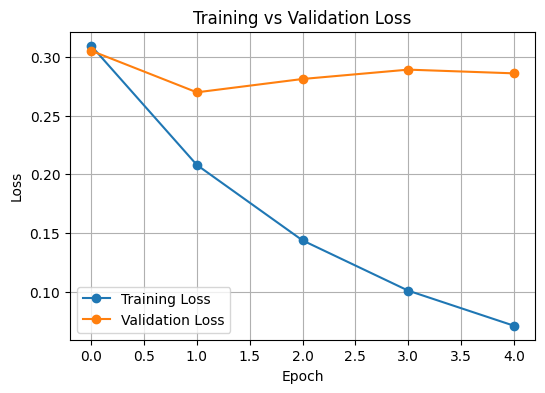

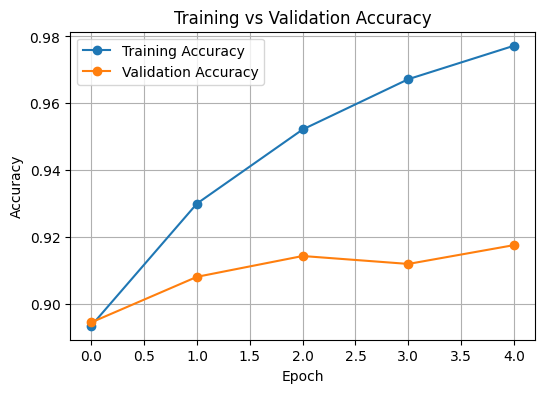

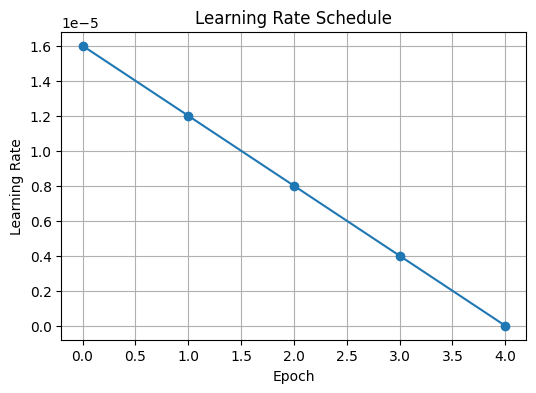

In [41]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accuracies, marker='o', label="Training Accuracy")
plt.plot(val_accuracies, marker='o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(learning_rates, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()



## 15.Model Evaluation Function

In [42]:
def evaluate_model(model, loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("\nClassification Report:\n")

    # ✅ Convert class names to string
    target_names = [str(cls) for cls in label_encoder.classes_]

    print(classification_report(
        all_labels,
        all_preds,
        target_names=target_names,
        digits=4
    ))


## 16.Load Best Model

In [43]:
import torch
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

evaluate_model(model, val_loader)


Accuracy: 0.9175807886154759

Classification Report:

              precision    recall  f1-score   support

           0     0.8792    0.8690    0.8741       687
           1     0.9239    0.9432    0.9335      1339
           2     0.9470    0.9265    0.9366       694
           3     0.9136    0.9066    0.9101       653

    accuracy                         0.9176      3373
   macro avg     0.9159    0.9113    0.9136      3373
weighted avg     0.9176    0.9176    0.9175      3373



## 17.Test Dataset Creation

In [44]:
print(df.columns)


Index(['text', 'label'], dtype='object')


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load full dataset
df = pd.read_csv("dataset.csv", sep="\t")


print("Original Dataset Size:", len(df))

# Split dataset (80% train, 20% test)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]  # keeps class balance
)

# Save test dataset
test_df.to_csv("test_dataset.csv", index=False)

print("Train size:", len(train_df))
print("Test size:", len(test_df))
print("test_dataset.csv created successfully!")


Original Dataset Size: 16861
Train size: 13488
Test size: 3373
test_dataset.csv created successfully!


## 18.Load Test Dataset

In [46]:
test_df = pd.read_csv("test_dataset.csv")

print(test_df.head())
print("Test Class Distribution:\n", test_df["label"].value_counts())


                        text  label
0           Old sweater 1606    TTR
1          plastic fork 1443  Black
2          jar of honey 3216   Blue
3                batteries 0    TTR
4  reusable grocery bag 9593   Blue
Test Class Distribution:
 label
Blue     1339
Green     694
Black     687
TTR       653
Name: count, dtype: int64


In [47]:
label_mapping = {
    "Black": 0,
    "Blue": 1,
    "Green": 2,
    "TTR": 3
}

test_df["label"] = test_df["label"].map(label_mapping)


## 19.Enocde Test Labels

In [48]:
test_texts = test_df["text"].values
test_labels = test_df["label"].values



## 20.Create Test Dataset & Dataloader

In [49]:


test_dataset = GarbageDataset(test_texts, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16)


## 21.Comprehensive Test Evalutaion

In [50]:
def evaluate_on_test(model, loader):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)

    print("Test Accuracy:", acc)
    print("\n Classification Report:\n")
    print(classification_report(
    all_labels,
    all_preds,
    digits=4
))


    return all_preds, all_labels


In [51]:
print(test_df[test_df["label"].isna()])


Empty DataFrame
Columns: [text, label]
Index: []


In [52]:
test_preds, test_labels_true = evaluate_on_test(model, test_loader)


Test Accuracy: 0.9175807886154759

 Classification Report:

              precision    recall  f1-score   support

           0     0.8792    0.8690    0.8741       687
           1     0.9239    0.9432    0.9335      1339
           2     0.9470    0.9265    0.9366       694
           3     0.9136    0.9066    0.9101       653

    accuracy                         0.9176      3373
   macro avg     0.9159    0.9113    0.9136      3373
weighted avg     0.9176    0.9176    0.9175      3373



## 22.Prediciton Function

In [53]:
def predict_text(text):
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    class_names = ["Black", "Blue", "Green", "TTR"]

    return class_names[prediction]


In [38]:
print(predict_text("plastic bottle"))
print(predict_text("banana peel"))
print(predict_text("old batteries"))


Blue
Green
TTR
